# Clustering Pop Song Lyric Themes by Decade

In this notebook, I will break the 48,000 pop songs into different decades and then run clustering on them to see what themes come up in each decade. Then I will run it on all the pop songs to see what it sees overall for themes. I'll be using a TFIDF Vectorizer and KMeans for the clustering, then I will look at the most used words in each cluster and make a word cloud for the whole decade.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import re
import string

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv("poplyricscleaned.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48027 entries, 0 to 48026
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             48027 non-null  object 
 1   artist            48027 non-null  object 
 2   tag               48027 non-null  object 
 3   year              48027 non-null  int64  
 4   lyrics            48027 non-null  object 
 5   album             48022 non-null  object 
 6   explicit          48027 non-null  bool   
 7   danceability      48027 non-null  float64
 8   energy            48027 non-null  float64
 9   key               48027 non-null  int64  
 10  loudness          48027 non-null  float64
 11  mode              48027 non-null  int64  
 12  speechiness       48027 non-null  float64
 13  acousticness      48027 non-null  float64
 14  instrumentalness  48027 non-null  float64
 15  liveness          48027 non-null  float64
 16  valence           48027 non-null  float6

In [6]:
df.head()

title           artist  tag  year  \
0           Idioteque        radiohead  pop  2000   
1         Billie Jean  michael jackson  pop  1982   
2             Holiday  vampire weekend  pop  2010   
3             Islands          shakira  pop  2010   
4  Hold It Against Me   britney spears  pop  2011   

                                              lyrics  \
0   Who's in the bunker? Who's in the bunker? Wom...   
1   She was more like a beauty queen from a movie...   
2   Holiday, oh, a holiday And the best one of th...   
3   I don't have to leave anymore What I have is ...   
4   Hey, over there Please forgive me if I'm comi...   

                           album  explicit  danceability  energy  key  ...  \
0                          Kid A     False         0.615   0.931    3  ...   
1                       Thriller     False         0.932   0.457   11  ...   
2                        Holiday     False         0.715   0.769    2  ...   
3                    Sale el Sol     False         0.778   0.760    8  ...   
4  Femme Fatale (Deluxe Version)     False         0.648   0.722    0  ...   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.2730        0.0352          0.000022    0.0915    0.525  137.544   
1       0.0541        0.0173          0.043600    0.0414    0.884  117.002   
2       0.1050        0.0230          0.000732    0.1270    0.891  155.827   
3       0.0450        0.1040          0.000018    0.1160    0.686  134.098   
4       0.0427        0.0103          0.000000    0.2400    0.389  132.973   

   duration_ms  time_signature  decade  \
0       309093             3.0   2000s   
1       294227             4.0   1980s   
2       138293             4.0   2010s   
3       162893             4.0   2010s   
4       228827             4.0   2010s   

                                      cleaned_lyrics  
0    bunker bunker woman child child child laugh ...  
1    like beauty queen movie scene say mind mean ...  
2    holiday oh holiday good year doze underneath...  
3    leave anymore right spend night day search w...  
4    hey forgive come strong hate stare win play ...  

[5 rows x 22 columns]

In [257]:
df['cleaned_lyrics'] = df['cleaned_lyrics'].astype('string')

I will make a separate dataframe for each decade, so that I can look at them individually. I'll also go ahead and pull the lyrics into variables so they are ready to use for each decade.

In [11]:
df['decade'].value_counts()

decade
2010s    17921
2000s    17153
1990s     6319
2020      3328
1980s     2130
1970s     1176
Name: count, dtype: int64

In [258]:
lyrics = df['cleaned_lyrics']

In [259]:
pop_70s = df[df['decade'] == '1970s']
pop_80s = df[df['decade'] == '1980s']
pop_90s = df[df['decade'] == '1990s']
pop_00s = df[df['decade'] == '2000s']
pop_10s = df[df['decade'] == '2010s']
pop_20s = df[df['decade'] == '2020']

In [260]:
lyrics_70s = pop_70s['cleaned_lyrics']
lyrics_80s = pop_80s['cleaned_lyrics']
lyrics_90s = pop_90s['cleaned_lyrics']
lyrics_00s = pop_00s['cleaned_lyrics']
lyrics_10s = pop_10s['cleaned_lyrics']
lyrics_20s = pop_20s['cleaned_lyrics']

## 1970s Clusters

1,176 songs

In [261]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_70s)
type(features)

scipy.sparse._csr.csr_matrix

In [262]:
features.shape

(1176, 3350)

In [263]:
features = features.todense()
features = np.array(features)

I am starting the model with 10 clusters and will look at silhouette scores to see if there may be a better number.

In [264]:
model = KMeans(n_clusters=10, random_state=42, n_init='auto')

In [265]:
model.fit(features)

KMeans(n_clusters=10, random_state=42)

In [266]:
cluster_labels = model.predict(features)

In [267]:
cluster_labels

array([9, 4, 9, ..., 1, 5, 7], dtype=int32)

In [268]:
np.bincount(cluster_labels)

array([ 57,  73,  54, 108, 118, 124,  79, 385,  97,  81])

There is a decent spread across the clusters. I will look at silhouette scores to see if there is another number of clusters that may work.

In [269]:
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [270]:
wss = []
for n in range(2, 31):
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_init='auto')
    model.fit(features)
    cluster_labels = model.predict(features)
    score = metrics.silhouette_score(features, cluster_labels)
    print('Silhouette score for ',n,' clusters: ',score)
    wss.append(-model.score(features))

2
Silhouette score for  2  clusters:  0.0025285973760241207
3
Silhouette score for  3  clusters:  0.0026901233653069136
4
Silhouette score for  4  clusters:  0.002870479429628454
5
Silhouette score for  5  clusters:  0.006732498529465254
6
Silhouette score for  6  clusters:  0.007599739911329713
7
Silhouette score for  7  clusters:  0.007881191169742117
8
Silhouette score for  8  clusters:  0.0077230154222138764
9
Silhouette score for  9  clusters:  0.0052072628107974655
10
Silhouette score for  10  clusters:  0.006630393417784657
11
Silhouette score for  11  clusters:  0.006938055657196657
12
Silhouette score for  12  clusters:  0.007421284410713985
13
Silhouette score for  13  clusters:  0.007048891561951337
14
Silhouette score for  14  clusters:  0.007148053125141455
15
Silhouette score for  15  clusters:  0.007489506700697742
16
Silhouette score for  16  clusters:  0.007490045042974597
17
Silhouette score for  17  clusters:  0.010033936149376456
18
Silhouette score for  18  cluster

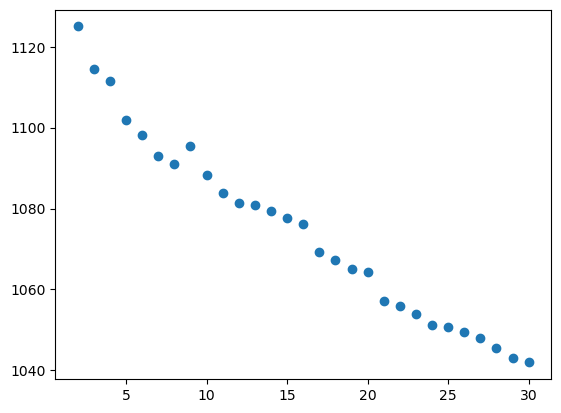

In [271]:
plt.scatter(range(2, 31), wss)

None of the scores are particularly great, but I can see a bit of an elbow at different values. 10 clusters actually appears to work decently for this so I will stick with that.

### 1970s Cluster Representations

The 1970s lyrics had 10 clusters. I will list the top 10 words in each cluster, then make a wordcloud for the 1970s lyrics overall. This will be helpful for looking for certain themes within this decade or overall.

In [272]:
from wordcloud import WordCloud

In [273]:
cluster0_70s = np.array(lyrics_70s)[cluster_labels == 0]
wordcount0_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_70s)))
wordcount0_70s.most_common(10)

[('know', 42),
 ('crazy', 38),
 ('daddy', 36),
 ('hello', 31),
 ('baby', 26),
 ('like', 25),
 ('big', 24),
 ('little', 24),
 ('oh', 21),
 ('drunk', 21)]

In [274]:
cluster1_70s = np.array(lyrics_70s)[cluster_labels == 1]
wordcount1_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_70s)))
wordcount1_70s.most_common(10)

[('cry', 83),
 ('long', 78),
 ('love', 39),
 ('escape', 29),
 ('know', 28),
 ('na', 24),
 ('like', 23),
 ('come', 21),
 ('think', 20),
 ('eye', 19)]

In [275]:
cluster2_70s = np.array(lyrics_70s)[cluster_labels == 2]
wordcount2_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_70s)))
wordcount2_70s.most_common(10)

[('na', 374),
 ('gon', 255),
 ('hey', 182),
 ('love', 169),
 ('know', 82),
 ('oh', 73),
 ('get', 72),
 ('day', 65),
 ('wan', 54),
 ('city', 48)]

In [276]:
cluster3_70s = np.array(lyrics_70s)[cluster_labels == 3]
wordcount3_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_70s)))
wordcount3_70s.most_common(10)

[('think', 219),
 ('love', 124),
 ('know', 113),
 ('bye', 89),
 ('like', 54),
 ('leave', 44),
 ('time', 41),
 ('life', 40),
 ('bluebird', 40),
 ('get', 39)]

In [277]:
cluster4_70s = np.array(lyrics_70s)[cluster_labels == 4]
wordcount4_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_70s)))
wordcount4_70s.most_common(10)

[('get', 51),
 ('chorus', 35),
 ('surely', 30),
 ('know', 27),
 ('youth', 18),
 ('way', 17),
 ('love', 17),
 ('department', 16),
 ('dirt', 16),
 ('like', 15)]

In [278]:
cluster5_70s = np.array(lyrics_70s)[cluster_labels == 5]
wordcount5_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_70s)))
wordcount5_70s.most_common(10)

[('man', 176),
 ('ooh', 125),
 ('like', 78),
 ('free', 77),
 ('sweet', 77),
 ('oh', 68),
 ('get', 64),
 ('know', 58),
 ('love', 48),
 ('come', 38)]

In [279]:
cluster6_70s = np.array(lyrics_70s)[cluster_labels == 6]
wordcount6_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_70s)))
wordcount6_70s.most_common(10)

[('fly', 96),
 ('walk', 67),
 ('night', 53),
 ('away', 51),
 ('stranger', 39),
 ('love', 33),
 ('sky', 29),
 ('morning', 29),
 ('sun', 27),
 ('time', 27)]

In [280]:
cluster7_70s = np.array(lyrics_70s)[cluster_labels == 7]
wordcount7_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_70s)))
wordcount7_70s.most_common(10)

[('love', 76),
 ('hurt', 55),
 ('tear', 49),
 ('know', 36),
 ('tell', 26),
 ('go', 23),
 ('inside', 22),
 ('oh', 21),
 ('good', 21),
 ('get', 21)]

In [281]:
cluster8_70s = np.array(lyrics_70s)[cluster_labels == 8]
wordcount8_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_70s)))
wordcount8_70s.most_common(10)

[('way', 84),
 ('light', 84),
 ('love', 83),
 ('night', 43),
 ('know', 41),
 ('like', 34),
 ('get', 32),
 ('life', 31),
 ('find', 30),
 ('away', 29)]

In [282]:
cluster9_70s = np.array(lyrics_70s)[cluster_labels == 9]
wordcount9_70s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_70s)))
wordcount9_70s.most_common(10)

[('yeah', 345),
 ('oh', 142),
 ('know', 84),
 ('love', 69),
 ('na', 67),
 ('come', 61),
 ('get', 58),
 ('shout', 48),
 ('dead', 44),
 ('wear', 43)]

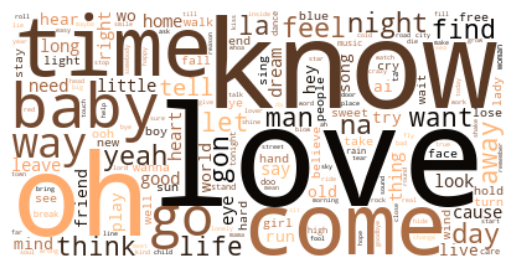

In [380]:
alllyrics_70s = np.array(lyrics_70s)
words_70s = ' '.join(alllyrics_70s)
wordcloud_70s = WordCloud(collocations=False, colormap="copper", background_color="white").generate(words_70s)
plt.imshow(wordcloud_70s, interpolation='bilinear')
plt.axis("off")
plt.show()

## 1980s Clusters

2,130 songs

In [40]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_80s)
type(features)

scipy.sparse._csr.csr_matrix

In [41]:
features.shape

(2130, 4894)

In [42]:
features = features.todense()
features = np.array(features)

I started with 10 clusters and after seeing the scores below, I changed it to 12 clusters to see if it improved since it leveled out a little at 12.

In [43]:
model = KMeans(n_clusters=12, random_state=42, n_init='auto')

In [44]:
model.fit(features)

KMeans(n_clusters=12, random_state=42)

In [45]:
cluster_labels = model.predict(features)

In [46]:
cluster_labels

array([ 2, 10,  7, ...,  2,  2,  8], dtype=int32)

In [47]:
np.bincount(cluster_labels)

array([ 34, 259, 885, 188,  82, 125, 104,  55,  82, 117, 109,  90])

Now I will look at silhouette scores to find the optimal number of clusters.

In [48]:
wss = []
for n in range(2, 31):
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_init='auto')
    model.fit(features)
    cluster_labels = model.predict(features)
    score = metrics.silhouette_score(features, cluster_labels)
    print('Silhouette score for ',n,' clusters: ',score)
    wss.append(-model.score(features))

2
Silhouette score for  2  clusters:  0.0025056633309343272
3
Silhouette score for  3  clusters:  0.0013061763971947567
4
Silhouette score for  4  clusters:  0.0017193120666498991
5
Silhouette score for  5  clusters:  0.0018820320872355164
6
Silhouette score for  6  clusters:  0.0020128340684519145
7
Silhouette score for  7  clusters:  0.002587380462572853
8
Silhouette score for  8  clusters:  0.0031101363409637
9
Silhouette score for  9  clusters:  0.0031716537359430777
10
Silhouette score for  10  clusters:  0.0039010141120268235
11
Silhouette score for  11  clusters:  0.004534904179769026
12
Silhouette score for  12  clusters:  0.00579937629373644
13
Silhouette score for  13  clusters:  0.005338132334123673
14
Silhouette score for  14  clusters:  0.005735434638392289
15
Silhouette score for  15  clusters:  0.005570109752704352
16
Silhouette score for  16  clusters:  0.006544308894168177
17
Silhouette score for  17  clusters:  0.006910917151597611
18
Silhouette score for  18  cluster

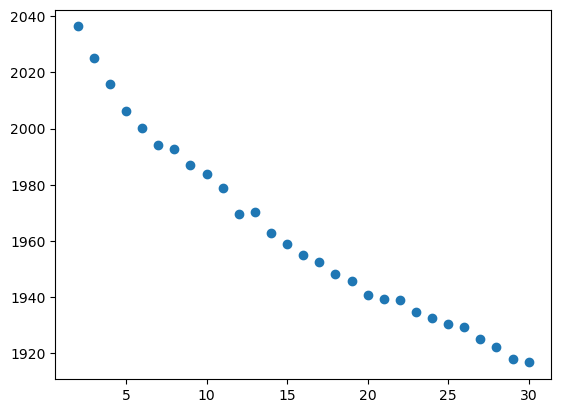

In [49]:
plt.scatter(range(2, 31), wss)

### 1980s Cluster Representations

This has 12 clusters, so I generated the top 10 words in each cluster and again made a wordcloud of the whole decade.

In [50]:
cluster0_80s = np.array(lyrics_80s)[cluster_labels == 0]
wordcount0_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_80s)))
wordcount0_80s.most_common(10)

[('white', 34),
 ('witch', 32),
 ('take', 14),
 ('laura', 11),
 ('laugh', 11),
 ('know', 11),
 ('think', 10),
 ('want', 9),
 ('cry', 7),
 ('way', 7)]

In [52]:
cluster1_80s = np.array(lyrics_80s)[cluster_labels == 1]
wordcount1_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_80s)))
wordcount1_80s.most_common(10)

[('chorus', 164),
 ('love', 92),
 ('know', 64),
 ('talk', 54),
 ('na', 48),
 ('think', 38),
 ('come', 34),
 ('get', 34),
 ('wan', 33),
 ('thing', 29)]

In [53]:
cluster2_80s = np.array(lyrics_80s)[cluster_labels == 2]
wordcount2_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_80s)))
wordcount2_80s.most_common(10)

[('know', 595),
 ('get', 483),
 ('come', 434),
 ('like', 404),
 ('love', 353),
 ('time', 311),
 ('man', 305),
 ('go', 270),
 ('say', 239),
 ('boy', 223)]

In [54]:
cluster3_80s = np.array(lyrics_80s)[cluster_labels == 3]
wordcount3_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_80s)))
wordcount3_80s.most_common(10)

[('love', 1934),
 ('know', 360),
 ('oh', 277),
 ('baby', 252),
 ('way', 204),
 ('get', 193),
 ('come', 187),
 ('heart', 176),
 ('hold', 159),
 ('like', 149)]

In [55]:
cluster4_80s = np.array(lyrics_80s)[cluster_labels == 4]
wordcount4_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_80s)))
wordcount4_80s.most_common(10)

[('want', 593),
 ('love', 146),
 ('know', 144),
 ('get', 101),
 ('like', 96),
 ('oh', 78),
 ('sweet', 77),
 ('need', 76),
 ('ya', 73),
 ('come', 62)]

In [56]:
cluster5_80s = np.array(lyrics_80s)[cluster_labels == 5]
wordcount5_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_80s)))
wordcount5_80s.most_common(10)

[('run', 259),
 ('fly', 96),
 ('come', 61),
 ('away', 61),
 ('hide', 36),
 ('save', 36),
 ('oh', 35),
 ('night', 32),
 ('say', 28),
 ('know', 23)]

In [57]:
cluster6_80s = np.array(lyrics_80s)[cluster_labels == 6]
wordcount6_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_80s)))
wordcount6_80s.most_common(10)

[('stand', 253),
 ('love', 71),
 ('get', 37),
 ('hand', 34),
 ('go', 33),
 ('time', 32),
 ('know', 28),
 ('long', 27),
 ('strike', 25),
 ('oh', 25)]

In [58]:
cluster7_80s = np.array(lyrics_80s)[cluster_labels == 7]
wordcount7_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_80s)))
wordcount7_80s.most_common(10)

[('blue', 158),
 ('fall', 135),
 ('like', 88),
 ('love', 80),
 ('come', 68),
 ('smile', 65),
 ('away', 61),
 ('hurt', 61),
 ('sky', 60),
 ('get', 55)]

In [59]:
cluster8_80s = np.array(lyrics_80s)[cluster_labels == 8]
wordcount8_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_80s)))
wordcount8_80s.most_common(10)

[('love', 538),
 ('know', 293),
 ('tell', 258),
 ('let', 222),
 ('heart', 201),
 ('stay', 177),
 ('away', 157),
 ('hold', 151),
 ('get', 139),
 ('time', 133)]

In [60]:
cluster9_80s = np.array(lyrics_80s)[cluster_labels == 9]
wordcount9_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_80s)))
wordcount9_80s.most_common(10)

[('na', 176),
 ('wan', 170),
 ('look', 151),
 ('head', 115),
 ('know', 98),
 ('fight', 75),
 ('dead', 66),
 ('get', 63),
 ('eye', 57),
 ('red', 53)]

In [61]:
cluster10_80s = np.array(lyrics_80s)[cluster_labels == 10]
wordcount10_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster10_80s)))
wordcount10_80s.most_common(10)

[('tonight', 350),
 ('love', 116),
 ('na', 115),
 ('gon', 81),
 ('oh', 60),
 ('baby', 58),
 ('right', 55),
 ('hold', 55),
 ('like', 52),
 ('night', 51)]

In [62]:
cluster11_80s = np.array(lyrics_80s)[cluster_labels == 11]
wordcount11_80s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster11_80s)))
wordcount11_80s.most_common(10)

[('girl', 772),
 ('oh', 217),
 ('na', 187),
 ('love', 186),
 ('wan', 162),
 ('know', 138),
 ('come', 115),
 ('fun', 74),
 ('like', 71),
 ('favorite', 69)]

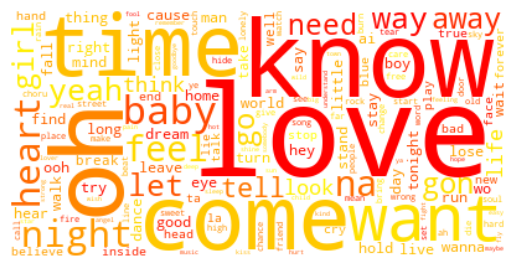

In [379]:
alllyrics_80s = np.array(lyrics_80s)
words_80s = ' '.join(alllyrics_80s)
wordcloud_80s = WordCloud(collocations=False, colormap="autumn", background_color="white").generate(words_80s)
plt.imshow(wordcloud_80s, interpolation='bilinear')
plt.axis("off")
plt.show()

## 1990s Clusters

6,319 songs

In [64]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_90s)
type(features)

scipy.sparse._csr.csr_matrix

In [65]:
features.shape

(6319, 10086)

In [66]:
features = features.todense()
features = np.array(features)

Again, I ran this with 10 clusters to start, then changed to 25 after looking at the silhouette score chart.

In [67]:
model = KMeans(n_clusters=25, random_state=42, n_init='auto')

In [68]:
model.fit(features)

KMeans(n_clusters=25, random_state=42)

In [69]:
cluster_labels = model.predict(features)

In [70]:
cluster_labels

array([0, 0, 0, ..., 0, 2, 2], dtype=int32)

In [71]:
np.bincount(cluster_labels)

array([1618,   96,  228,   86,  242,  224,  177,  145,  328,   52,  460,
        174,  174,  660,  196,  113,   33,  108,   33,  165,  126,   78,
        237,  316,  250])

Now I will look at silhouette scores to find the optimal number of clusters.

In [46]:
wss = []
for n in range(2, 30):
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_init='auto')
    model.fit(features)
    cluster_labels = model.predict(features)
    score = metrics.silhouette_score(features, cluster_labels)
    print('Silhouette score for ',n,' clusters: ',score)
    wss.append(-model.score(features))

2
Silhouette score for  2  clusters:  -0.00015742536257708881
3
Silhouette score for  3  clusters:  -0.0004969257741874921
4
Silhouette score for  4  clusters:  0.00035002477624039737
5
Silhouette score for  5  clusters:  0.0010213631509210187
6
Silhouette score for  6  clusters:  0.0010257235692761484
7
Silhouette score for  7  clusters:  0.001569042175484921
8
Silhouette score for  8  clusters:  0.0013241670753778385
9
Silhouette score for  9  clusters:  0.0018354443384563704
10
Silhouette score for  10  clusters:  0.002027985964911813
11
Silhouette score for  11  clusters:  0.002344722972004874
12
Silhouette score for  12  clusters:  0.0027992146633933875
13
Silhouette score for  13  clusters:  0.0038901136213351836
14
Silhouette score for  14  clusters:  0.0044958127525643885
15
Silhouette score for  15  clusters:  0.004882274285125328
16
Silhouette score for  16  clusters:  0.00500979712905335
17
Silhouette score for  17  clusters:  0.0051617599283834276
18
Silhouette score for  1

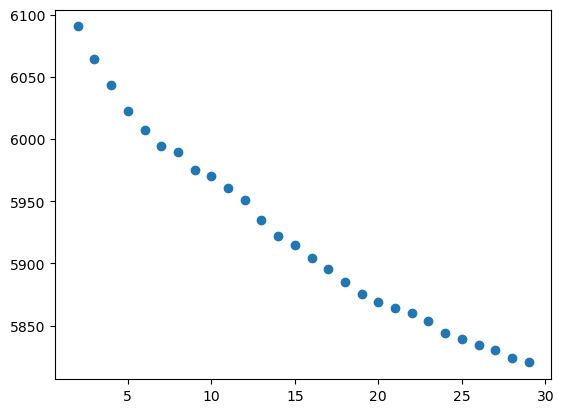

In [47]:
plt.scatter(range(2, 30), wss)

Not much of an elbow on this, but I'll go back and try 25 clusters to see how it looks.

### 1990s Cluster Representations

Twenty five clusters for the 1990s! Since I am using this decade to highlight for my presentation, I am creating word clouds for each cluster along with the top 10 words.

In [72]:
cluster0_90s = np.array(lyrics_90s)[cluster_labels == 0]
wordcount0_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_90s)))
wordcount0_90s.most_common(10)

[('like', 1113),
 ('come', 1066),
 ('know', 1020),
 ('get', 887),
 ('love', 879),
 ('oh', 690),
 ('time', 666),
 ('man', 599),
 ('hey', 578),
 ('feel', 571)]

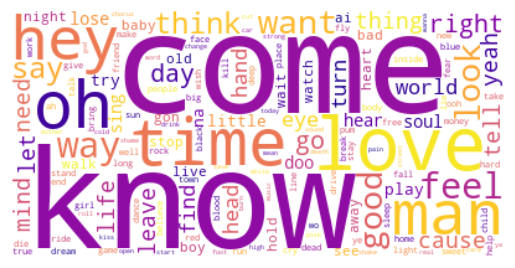

In [385]:
cluster0_90s_words= ' '.join(cluster0_90s)
wordcloud0_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster0_90s_words)
plt.imshow(wordcloud0_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [73]:
cluster1_90s = np.array(lyrics_90s)[cluster_labels == 1]
wordcount1_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_90s)))
wordcount1_90s.most_common(10)

[('burn', 414),
 ('fire', 268),
 ('like', 102),
 ('know', 86),
 ('come', 81),
 ('ground', 73),
 ('love', 67),
 ('feel', 62),
 ('get', 59),
 ('life', 58)]

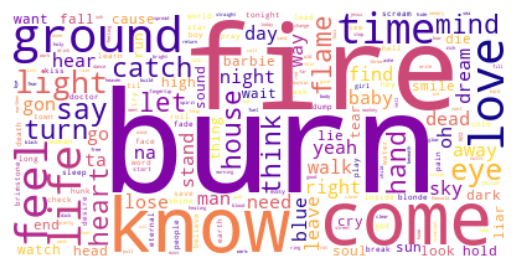

In [386]:
cluster1_90s_words= ' '.join(cluster1_90s)
wordcloud1_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster1_90s_words)
plt.imshow(wordcloud1_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [74]:
cluster2_90s = np.array(lyrics_90s)[cluster_labels == 2]
wordcount2_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_90s)))
wordcount2_90s.most_common(10)

[('god', 584),
 ('jesus', 296),
 ('come', 218),
 ('lord', 211),
 ('holy', 196),
 ('love', 188),
 ('know', 166),
 ('blood', 144),
 ('sing', 133),
 ('glory', 131)]

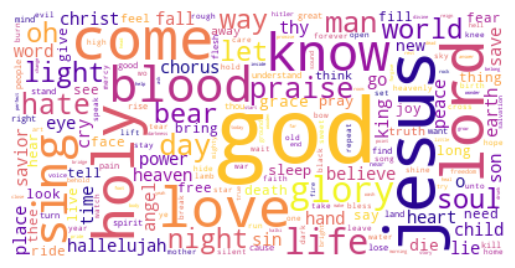

In [387]:
cluster2_90s_words= ' '.join(cluster2_90s)
wordcloud2_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster2_90s_words)
plt.imshow(wordcloud2_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
cluster3_90s = np.array(lyrics_90s)[cluster_labels == 3]
wordcount3_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_80s)))
wordcount3_90s.most_common(10)

[('na', 781),
 ('wan', 742),
 ('like', 150),
 ('know', 140),
 ('baby', 131),
 ('love', 124),
 ('want', 107),
 ('get', 92),
 ('feel', 88),
 ('think', 79)]

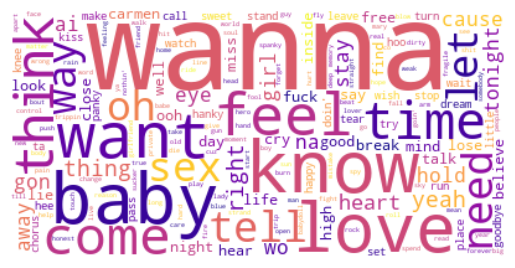

In [388]:
cluster3_90s_words= ' '.join(cluster3_90s)
wordcloud3_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster3_90s_words)
plt.imshow(wordcloud3_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [76]:
cluster4_90s = np.array(lyrics_90s)[cluster_labels == 4]
wordcount4_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_90s)))
wordcount4_90s.most_common(10)

[('day', 906),
 ('dream', 466),
 ('know', 308),
 ('come', 268),
 ('way', 209),
 ('like', 191),
 ('time', 185),
 ('love', 178),
 ('night', 177),
 ('life', 142)]

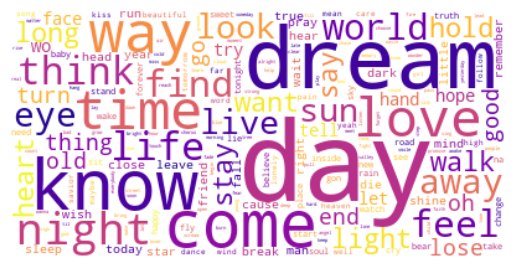

In [389]:
cluster4_90s_words= ' '.join(cluster4_90s)
wordcloud4_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster4_90s_words)
plt.imshow(wordcloud4_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
cluster5_90s = np.array(lyrics_90s)[cluster_labels == 5]
wordcount5_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_90s)))
wordcount5_90s.most_common(10)

[('go', 814),
 ('come', 593),
 ('home', 327),
 ('long', 271),
 ('know', 221),
 ('like', 203),
 ('love', 157),
 ('feel', 155),
 ('way', 148),
 ('good', 137)]

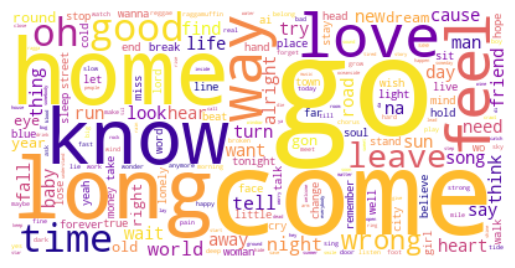

In [390]:
cluster5_90s_words= ' '.join(cluster5_90s)
wordcloud5_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster5_90s_words)
plt.imshow(wordcloud5_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
cluster6_90s = np.array(lyrics_90s)[cluster_labels == 6]
wordcount6_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_90s)))
wordcount6_90s.most_common(10)

[('na', 1510),
 ('gon', 1032),
 ('love', 259),
 ('know', 254),
 ('like', 220),
 ('get', 192),
 ('time', 191),
 ('yeah', 150),
 ('come', 147),
 ('way', 140)]

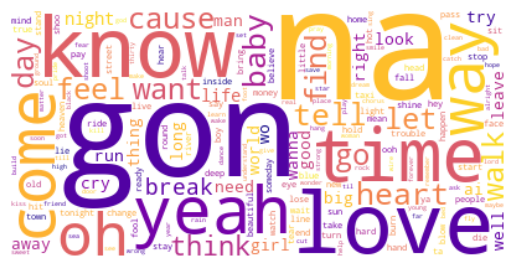

In [391]:
cluster6_90s_words= ' '.join(cluster6_90s)
wordcloud6_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster6_90s_words)
plt.imshow(wordcloud6_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
cluster7_90s = np.array(lyrics_90s)[cluster_labels == 7]
wordcount7_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_90s)))
wordcount7_90s.most_common(10)

[('yeah', 1234),
 ('oh', 317),
 ('like', 231),
 ('know', 210),
 ('get', 159),
 ('love', 149),
 ('come', 120),
 ('ooh', 114),
 ('time', 113),
 ('feel', 112)]

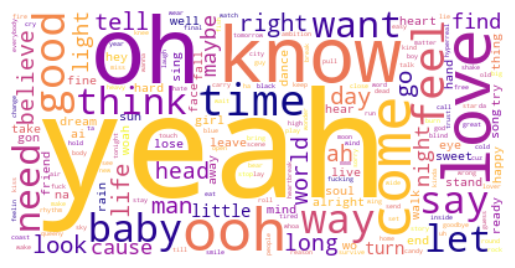

In [392]:
cluster7_90s_words= ' '.join(cluster7_90s)
wordcloud7_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster7_90s_words)
plt.imshow(wordcloud7_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
cluster8_90s = np.array(lyrics_90s)[cluster_labels == 8]
wordcount8_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_90s)))
wordcount8_90s.most_common(10)

[('heart', 506),
 ('lie', 389),
 ('word', 353),
 ('hear', 334),
 ('like', 330),
 ('know', 281),
 ('break', 265),
 ('love', 262),
 ('fall', 248),
 ('feel', 217)]

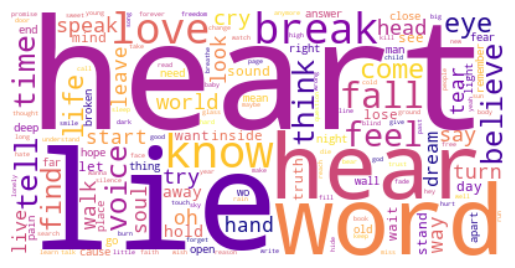

In [393]:
cluster8_90s_words= ' '.join(cluster8_90s)
wordcloud8_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster8_90s_words)
plt.imshow(wordcloud8_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
cluster9_90s = np.array(lyrics_90s)[cluster_labels == 9]
wordcount9_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_90s)))
wordcount9_90s.most_common(10)

[('christmas', 417),
 ('oh', 107),
 ('time', 106),
 ('day', 105),
 ('love', 88),
 ('bell', 74),
 ('night', 72),
 ('merry', 71),
 ('know', 64),
 ('tree', 56)]

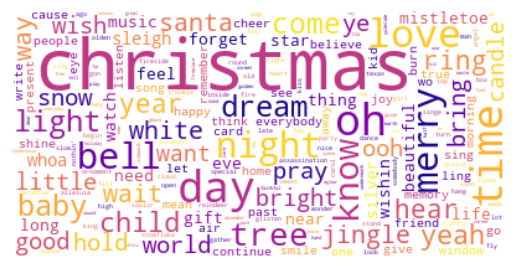

In [394]:
cluster9_90s_words= ' '.join(cluster9_90s)
wordcloud9_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster9_90s_words)
plt.imshow(wordcloud9_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [82]:
cluster10_90s = np.array(lyrics_90s)[cluster_labels == 10]
wordcount10_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster10_90s)))
wordcount10_90s.most_common(10)

[('night', 635),
 ('like', 456),
 ('come', 426),
 ('eye', 372),
 ('love', 361),
 ('feel', 340),
 ('light', 304),
 ('rain', 290),
 ('know', 283),
 ('close', 281)]

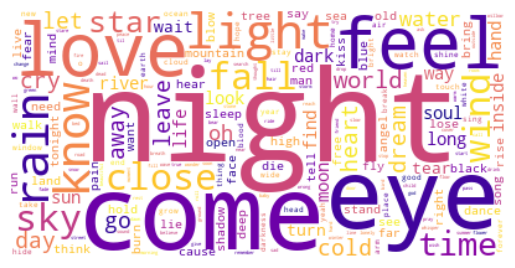

In [395]:
cluster10_90s_words= ' '.join(cluster10_90s)
wordcloud10_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster10_90s_words)
plt.imshow(wordcloud10_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [83]:
cluster11_90s = np.array(lyrics_90s)[cluster_labels == 11]
wordcount11_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster11_90s)))
wordcount11_90s.most_common(10)

[('baby', 1417),
 ('oh', 525),
 ('love', 474),
 ('know', 361),
 ('come', 276),
 ('like', 262),
 ('get', 182),
 ('let', 162),
 ('na', 160),
 ('time', 159)]

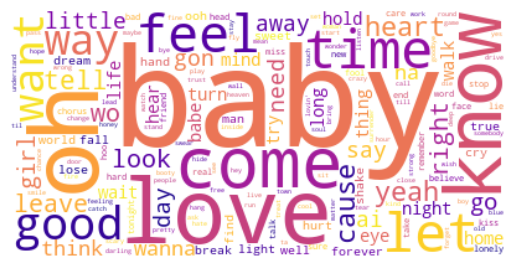

In [396]:
cluster11_90s_words= ' '.join(cluster11_90s)
wordcloud11_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster11_90s_words)
plt.imshow(wordcloud11_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [85]:
cluster12_90s = np.array(lyrics_90s)[cluster_labels == 12]
wordcount12_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster12_90s)))
wordcount12_90s.most_common(10)

[('want', 1212),
 ('know', 347),
 ('love', 180),
 ('like', 168),
 ('oh', 163),
 ('get', 137),
 ('believe', 135),
 ('feel', 133),
 ('come', 120),
 ('need', 112)]

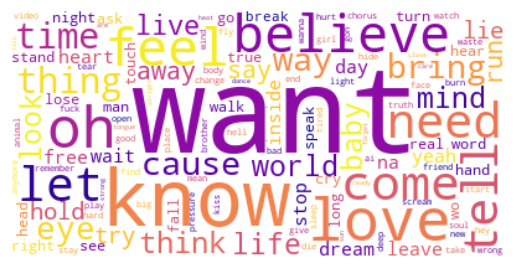

In [397]:
cluster12_90s_words= ' '.join(cluster12_90s)
wordcloud12_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster12_90s_words)
plt.imshow(wordcloud12_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [86]:
cluster13_90s = np.array(lyrics_90s)[cluster_labels == 13]
wordcount13_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster13_90s)))
wordcount13_90s.most_common(10)

[('know', 1860),
 ('life', 903),
 ('like', 863),
 ('way', 648),
 ('look', 631),
 ('man', 593),
 ('come', 579),
 ('feel', 570),
 ('thing', 534),
 ('love', 484)]

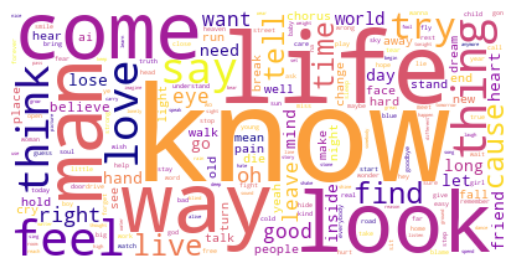

In [398]:
cluster13_90s_words= ' '.join(cluster13_90s)
wordcloud13_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster13_90s_words)
plt.imshow(wordcloud13_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [87]:
cluster14_90s = np.array(lyrics_90s)[cluster_labels == 14]
wordcount14_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster14_90s)))
wordcount14_90s.most_common(10)

[('little', 831),
 ('girl', 687),
 ('know', 279),
 ('love', 269),
 ('like', 231),
 ('come', 223),
 ('oh', 176),
 ('get', 174),
 ('world', 158),
 ('think', 157)]

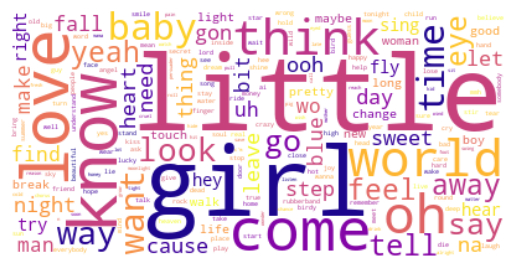

In [399]:
cluster14_90s_words= ' '.join(cluster14_90s)
wordcloud14_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster14_90s_words)
plt.imshow(wordcloud14_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [88]:
cluster15_90s = np.array(lyrics_90s)[cluster_labels == 15]
wordcount15_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster15_90s)))
wordcount15_90s.most_common(10)

[('wo', 400),
 ('know', 216),
 ('care', 148),
 ('love', 108),
 ('like', 85),
 ('come', 85),
 ('try', 83),
 ('heart', 71),
 ('=', 70),
 ('time', 67)]

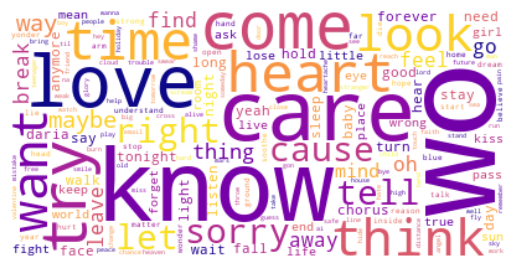

In [400]:
cluster15_90s_words= ' '.join(cluster15_90s)
wordcloud15_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster15_90s_words)
plt.imshow(wordcloud15_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
cluster16_90s = np.array(lyrics_90s)[cluster_labels == 16]
wordcount16_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster16_90s)))
wordcount16_90s.most_common(10)

[('la', 897),
 ('love', 121),
 ('ooh', 87),
 ('know', 51),
 ('oh', 49),
 ('come', 44),
 ('na', 44),
 ('go', 42),
 ('like', 35),
 ('want', 34)]

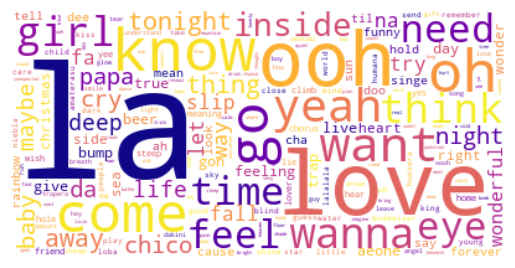

In [401]:
cluster16_90s_words= ' '.join(cluster16_90s)
wordcloud16_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster16_90s_words)
plt.imshow(wordcloud16_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [90]:
cluster17_90s = np.array(lyrics_90s)[cluster_labels == 17]
wordcount17_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster17_90s)))
wordcount17_90s.most_common(10)

[('need', 831),
 ('love', 293),
 ('know', 280),
 ('oh', 136),
 ('want', 135),
 ('baby', 123),
 ('tell', 118),
 ('heart', 116),
 ('time', 90),
 ('get', 75)]

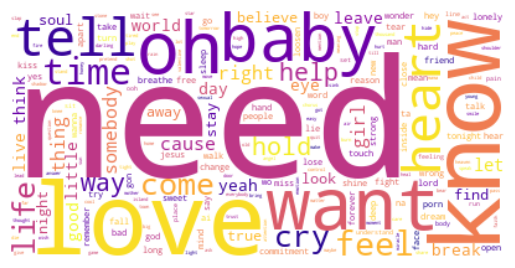

In [402]:
cluster17_90s_words= ' '.join(cluster17_90s)
wordcloud17_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster17_90s_words)
plt.imshow(wordcloud17_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
cluster18_90s = np.array(lyrics_90s)[cluster_labels == 18]
wordcount18_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster18_90s)))
wordcount18_90s.most_common(10)

[('train', 254),
 ('look', 53),
 ('know', 43),
 ('hear', 42),
 ('leave', 41),
 ('come', 31),
 ('say', 31),
 ('ride', 31),
 ('baby', 26),
 ('old', 24)]

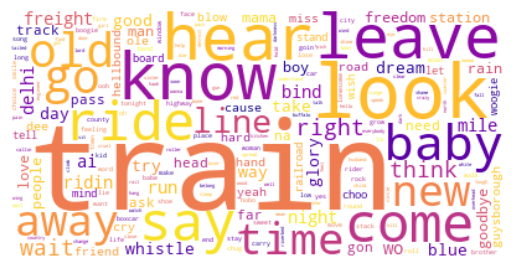

In [403]:
cluster18_90s_words= ' '.join(cluster18_90s)
wordcloud18_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster18_90s_words)
plt.imshow(wordcloud18_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
cluster19_90s = np.array(lyrics_90s)[cluster_labels == 19]
wordcount19_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster19_90s)))
wordcount19_90s.most_common(10)

[('away', 860),
 ('know', 165),
 ('far', 151),
 ('go', 143),
 ('day', 134),
 ('way', 128),
 ('feel', 123),
 ('time', 114),
 ('love', 111),
 ('walk', 109)]

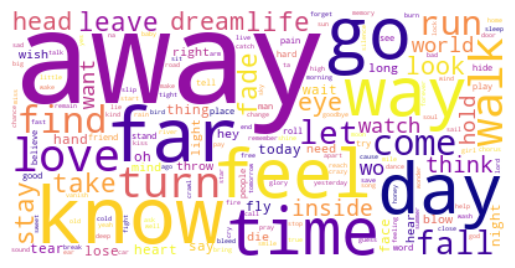

In [404]:
cluster19_90s_words= ' '.join(cluster19_90s)
wordcloud19_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster19_90s_words)
plt.imshow(wordcloud19_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [93]:
cluster20_90s = np.array(lyrics_90s)[cluster_labels == 20]
wordcount20_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster20_90s)))
wordcount20_90s.most_common(10)

[('let', 1103),
 ('know', 231),
 ('love', 176),
 ('time', 145),
 ('get', 118),
 ('like', 99),
 ('come', 97),
 ('baby', 91),
 ('wo', 84),
 ('heart', 82)]

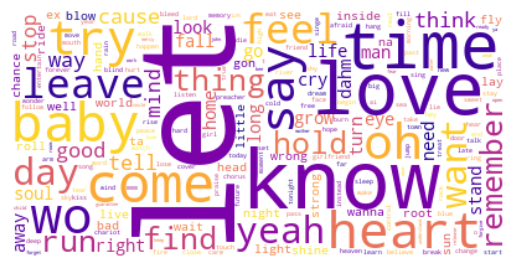

In [405]:
cluster20_90s_words= ' '.join(cluster20_90s)
wordcloud20_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster20_90s_words)
plt.imshow(wordcloud20_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [94]:
cluster21_90s = np.array(lyrics_90s)[cluster_labels == 21]
wordcount21_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster21_90s)))
wordcount21_90s.most_common(10)

[('fuck', 187),
 ('know', 168),
 ('shit', 133),
 ('like', 130),
 ('get', 116),
 ('crazy', 99),
 ('think', 97),
 ('nigga', 96),
 ('time', 95),
 ('ai', 81)]

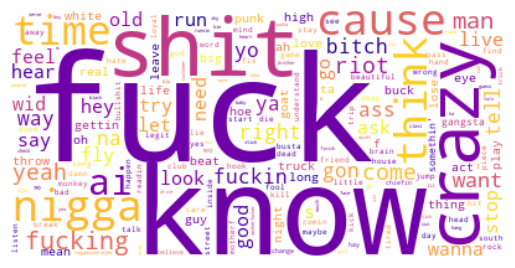

In [406]:
cluster21_90s_words= ' '.join(cluster21_90s)
wordcloud21_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster21_90s_words)
plt.imshow(wordcloud21_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [95]:
cluster22_90s = np.array(lyrics_90s)[cluster_labels == 22]
wordcount22_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster22_90s)))
wordcount22_90s.most_common(10)

[('time', 1387),
 ('know', 323),
 ('think', 214),
 ('come', 208),
 ('love', 191),
 ('like', 144),
 ('feel', 141),
 ('get', 139),
 ('tell', 138),
 ('life', 130)]

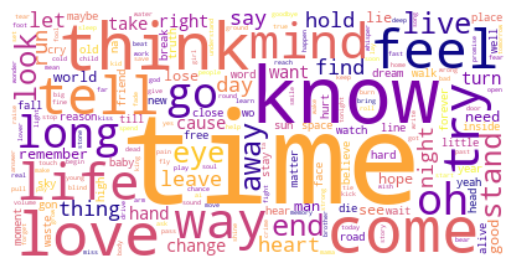

In [408]:
cluster22_90s_words= ' '.join(cluster22_90s)
wordcloud22_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster22_90s_words)
plt.imshow(wordcloud22_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [96]:
cluster23_90s = np.array(lyrics_90s)[cluster_labels == 23]
wordcount23_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster23_90s)))
wordcount23_90s.most_common(10)

[('love', 3491),
 ('know', 568),
 ('feel', 358),
 ('way', 298),
 ('time', 295),
 ('heart', 292),
 ('come', 280),
 ('like', 269),
 ('oh', 245),
 ('life', 224)]

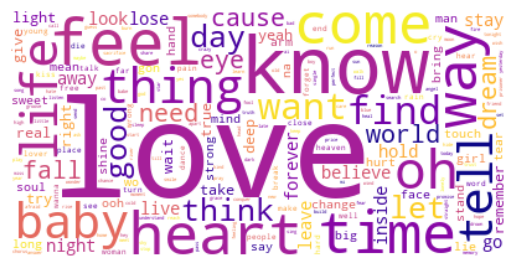

In [409]:
cluster23_90s_words= ' '.join(cluster23_90s)
wordcloud23_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster23_90s_words)
plt.imshow(wordcloud23_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [97]:
cluster24_90s = np.array(lyrics_90s)[cluster_labels == 24]
wordcount24_90s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster24_90s)))
wordcount24_90s.most_common(10)

[('get', 1677),
 ('know', 385),
 ('ta', 293),
 ('like', 286),
 ('time', 226),
 ('love', 215),
 ('come', 214),
 ('ai', 174),
 ('look', 159),
 ('thing', 159)]

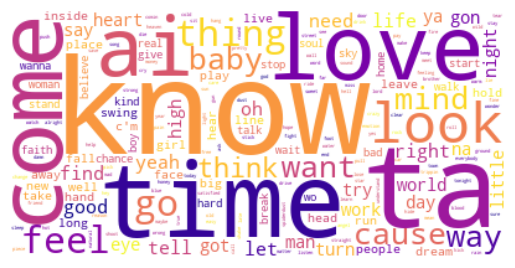

In [410]:
cluster24_90s_words= ' '.join(cluster24_90s)
wordcloud24_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(cluster24_90s_words)
plt.imshow(wordcloud24_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

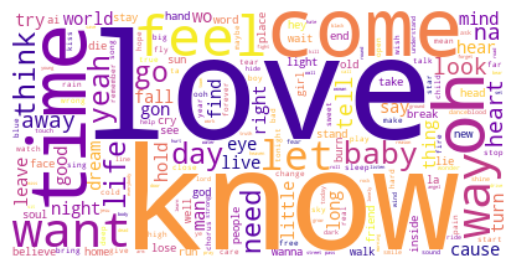

In [383]:
alllyrics_90s = np.array(lyrics_90s)
words_90s = ' '.join(alllyrics_90s)
wordcloud_90s = WordCloud(collocations=False, colormap="plasma", background_color="white").generate(words_90s)
plt.imshow(wordcloud_90s, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2000s Clusters

17,153 songs

In [98]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_00s)
type(features)

scipy.sparse._csr.csr_matrix

In [99]:
features.shape

(17153, 17538)

In [100]:
features = features.todense()
features = np.array(features)

Since this decade has more songs, I started with a higher number of clusters.

In [141]:
model = KMeans(n_clusters=25, random_state=42, n_init='auto')

In [142]:
model.fit(features)

KMeans(n_clusters=25, random_state=42)

In [143]:
cluster_labels = model.predict(features)

In [144]:
cluster_labels

array([ 6,  5, 11, ..., 20, 19, 11], dtype=int32)

In [145]:
np.bincount(cluster_labels)

array([ 259, 2404,  374,  322,  301, 1389,  492,  295,  275,  429,   86,
       5204,  652,  514,  374,  509,  435,  475,  706,  233,  287,  259,
         92,  238,  549])

For the sake of time and memory, I am not running silhouette scores for this decade. Twenty five and fifty clusters performed about the same, with one to three larger clusters and then the others smaller.

### 2000s Cluster Representations

Twenty five clusters for the 2000s!

In [146]:
cluster0_00s = np.array(lyrics_00s)[cluster_labels == 0]
wordcount0_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_00s)))
wordcount0_00s.most_common(10)

[('lord', 833),
 ('jesus', 557),
 ('god', 441),
 ('holy', 413),
 ('love', 330),
 ('praise', 233),
 ('oh', 219),
 ('night', 218),
 ('come', 192),
 ('heart', 190)]

In [147]:
cluster1_00s = np.array(lyrics_00s)[cluster_labels == 1]
wordcount1_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_00s)))
wordcount1_00s.most_common(10)

[('life', 2447),
 ('eye', 1760),
 ('light', 1616),
 ('fall', 1499),
 ('day', 1370),
 ('time', 1316),
 ('know', 1304),
 ('night', 1298),
 ('come', 1286),
 ('world', 1245)]

In [148]:
cluster2_00s = np.array(lyrics_00s)[cluster_labels == 2]
wordcount2_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_00s)))
wordcount2_00s.most_common(10)

[('oh', 4985),
 ('know', 521),
 ('love', 480),
 ('like', 380),
 ('come', 366),
 ('let', 344),
 ('feel', 309),
 ('way', 295),
 ('get', 291),
 ('time', 279)]

In [149]:
cluster3_00s = np.array(lyrics_00s)[cluster_labels == 3]
wordcount3_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_00s)))
wordcount3_00s.most_common(10)

[('dream', 1585),
 ('know', 303),
 ('night', 263),
 ('come', 247),
 ('like', 231),
 ('day', 217),
 ('love', 209),
 ('life', 183),
 ('away', 181),
 ('time', 165)]

In [150]:
cluster4_00s = np.array(lyrics_00s)[cluster_labels == 4]
wordcount4_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_00s)))
wordcount4_00s.most_common(10)

[('sing', 1103),
 ('song', 836),
 ('know', 313),
 ('love', 278),
 ('come', 234),
 ('let', 229),
 ('hear', 217),
 ('like', 199),
 ('heart', 170),
 ('feel', 144)]

In [151]:
cluster5_00s = np.array(lyrics_00s)[cluster_labels == 5]
wordcount5_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_00s)))
wordcount5_00s.most_common(10)

[('know', 6058),
 ('think', 1612),
 ('let', 1440),
 ('way', 1369),
 ('love', 1213),
 ('tell', 1185),
 ('thing', 1136),
 ('time', 1042),
 ('feel', 990),
 ('like', 949)]

In [152]:
cluster6_00s = np.array(lyrics_00s)[cluster_labels == 6]
wordcount6_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_00s)))
wordcount6_00s.most_common(10)

[('come', 3652),
 ('know', 486),
 ('let', 448),
 ('love', 402),
 ('time', 361),
 ('like', 352),
 ('go', 296),
 ('home', 293),
 ('feel', 286),
 ('oh', 254)]

In [153]:
cluster7_00s = np.array(lyrics_00s)[cluster_labels == 7]
wordcount7_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_00s)))
wordcount7_00s.most_common(10)

[('baby', 2376),
 ('know', 631),
 ('love', 615),
 ('oh', 439),
 ('get', 388),
 ('na', 350),
 ('let', 329),
 ('like', 325),
 ('come', 296),
 ('yeah', 274)]

In [154]:
cluster8_00s = np.array(lyrics_00s)[cluster_labels == 8]
wordcount8_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_00s)))
wordcount8_00s.most_common(10)

[('need', 1839),
 ('know', 449),
 ('love', 319),
 ('like', 258),
 ('want', 251),
 ('feel', 234),
 ('get', 216),
 ('way', 194),
 ('tell', 180),
 ('let', 173)]

In [155]:
cluster9_00s = np.array(lyrics_00s)[cluster_labels == 9]
wordcount9_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_00s)))
wordcount9_00s.most_common(10)

[('want', 3070),
 ('know', 619),
 ('love', 421),
 ('feel', 365),
 ('like', 364),
 ('come', 295),
 ('time', 278),
 ('get', 264),
 ('tell', 250),
 ('way', 231)]

In [156]:
cluster10_00s = np.array(lyrics_00s)[cluster_labels == 10]
wordcount10_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster10_00s)))
wordcount10_00s.most_common(10)

[('la', 2217),
 ('love', 183),
 ('da', 163),
 ('oh', 135),
 ('know', 128),
 ('like', 105),
 ('na', 101),
 ('get', 100),
 ('way', 90),
 ('come', 82)]

In [157]:
cluster11_00s = np.array(lyrics_00s)[cluster_labels == 11]
wordcount11_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster11_00s)))
wordcount11_00s.most_common(10)

[('know', 3177),
 ('like', 3142),
 ('come', 2783),
 ('get', 2778),
 ('love', 2464),
 ('time', 2341),
 ('man', 2236),
 ('oh', 2107),
 ('way', 1957),
 ('day', 1893)]

In [158]:
cluster12_00s = np.array(lyrics_00s)[cluster_labels == 12]
wordcount12_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster12_00s)))
wordcount12_00s.most_common(10)

[('love', 6471),
 ('know', 1045),
 ('heart', 626),
 ('like', 591),
 ('feel', 577),
 ('time', 471),
 ('come', 430),
 ('get', 401),
 ('fall', 400),
 ('oh', 392)]

In [159]:
cluster13_00s = np.array(lyrics_00s)[cluster_labels == 13]
wordcount13_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster13_00s)))
wordcount13_00s.most_common(10)

[('go', 1781),
 ('long', 1354),
 ('home', 536),
 ('know', 532),
 ('way', 525),
 ('time', 480),
 ('come', 390),
 ('day', 351),
 ('like', 314),
 ('think', 294)]

In [160]:
cluster14_00s = np.array(lyrics_00s)[cluster_labels == 14]
wordcount14_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster14_00s)))
wordcount14_00s.most_common(10)

[('try', 1477),
 ('know', 541),
 ('way', 360),
 ('time', 314),
 ('like', 302),
 ('think', 258),
 ('let', 236),
 ('love', 225),
 ('feel', 216),
 ('day', 215)]

In [161]:
cluster15_00s = np.array(lyrics_00s)[cluster_labels == 15]
wordcount15_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster15_00s)))
wordcount15_00s.most_common(10)

[('away', 2927),
 ('day', 483),
 ('know', 477),
 ('time', 399),
 ('come', 365),
 ('feel', 340),
 ('love', 310),
 ('like', 304),
 ('way', 301),
 ('far', 277)]

In [162]:
cluster16_00s = np.array(lyrics_00s)[cluster_labels == 16]
wordcount16_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster16_00s)))
wordcount16_00s.most_common(10)

[('na', 4261),
 ('gon', 2579),
 ('know', 811),
 ('love', 514),
 ('come', 455),
 ('get', 448),
 ('time', 431),
 ('way', 384),
 ('like', 348),
 ('tell', 331)]

In [163]:
cluster17_00s = np.array(lyrics_00s)[cluster_labels == 17]
wordcount17_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster17_00s)))
wordcount17_00s.most_common(10)

[('time', 3412),
 ('know', 548),
 ('feel', 387),
 ('love', 353),
 ('like', 335),
 ('find', 328),
 ('life', 321),
 ('come', 319),
 ('think', 289),
 ('get', 289)]

In [164]:
cluster18_00s = np.array(lyrics_00s)[cluster_labels == 18]
wordcount18_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster18_00s)))
wordcount18_00s.most_common(10)

[('like', 4400),
 ('feel', 1284),
 ('know', 828),
 ('way', 512),
 ('get', 495),
 ('love', 464),
 ('look', 457),
 ('time', 456),
 ('think', 416),
 ('come', 412)]

In [165]:
cluster19_00s = np.array(lyrics_00s)[cluster_labels == 19]
wordcount19_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster19_00s)))
wordcount19_00s.most_common(10)

[('na', 2151),
 ('wan', 2042),
 ('know', 585),
 ('love', 353),
 ('let', 283),
 ('want', 266),
 ('like', 261),
 ('feel', 249),
 ('come', 231),
 ('get', 215)]

In [166]:
cluster20_00s = np.array(lyrics_00s)[cluster_labels == 20]
wordcount20_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster20_00s)))
wordcount20_00s.most_common(10)

[('yeah', 2601),
 ('know', 526),
 ('oh', 515),
 ('get', 371),
 ('love', 348),
 ('come', 294),
 ('like', 271),
 ('way', 263),
 ('let', 262),
 ('na', 248)]

In [167]:
cluster21_00s = np.array(lyrics_00s)[cluster_labels == 21]
wordcount21_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster21_00s)))
wordcount21_00s.most_common(10)

[('hold', 1327),
 ('let', 327),
 ('know', 301),
 ('love', 262),
 ('hand', 238),
 ('heart', 210),
 ('like', 202),
 ('feel', 196),
 ('fall', 172),
 ('time', 171)]

In [168]:
cluster22_00s = np.array(lyrics_00s)[cluster_labels == 22]
wordcount22_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster22_00s)))
wordcount22_00s.most_common(10)

[('christmas', 664),
 ('merry', 182),
 ('day', 151),
 ('night', 101),
 ('dream', 88),
 ('white', 88),
 ('light', 86),
 ('year', 81),
 ('time', 80),
 ('like', 78)]

In [169]:
cluster23_00s = np.array(lyrics_00s)[cluster_labels == 23]
wordcount23_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster23_00s)))
wordcount23_00s.most_common(10)

[('hey', 1664),
 ('da', 1028),
 ('ooh', 626),
 ('like', 368),
 ('know', 331),
 ('love', 290),
 ('oh', 237),
 ('come', 227),
 ('get', 215),
 ('let', 181)]

In [170]:
cluster24_00s = np.array(lyrics_00s)[cluster_labels == 24]
wordcount24_00s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster24_00s)))
wordcount24_00s.most_common(10)

[('get', 3980),
 ('ta', 1195),
 ('know', 1005),
 ('like', 612),
 ('let', 540),
 ('time', 512),
 ('ai', 492),
 ('love', 470),
 ('come', 460),
 ('way', 454)]

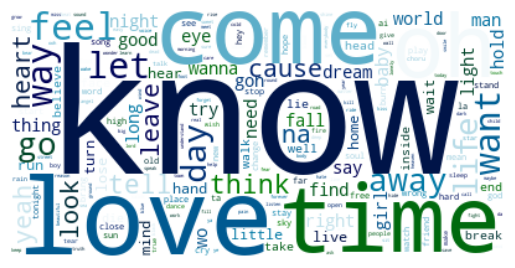

In [384]:
alllyrics_00s = np.array(lyrics_00s)
words_00s = ' '.join(alllyrics_00s)
wordcloud_00s = WordCloud(collocations=False, colormap="ocean", background_color="white").generate(words_00s)
plt.imshow(wordcloud_00s, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2010s Clusters

17,921 songs

In [172]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_10s)
type(features)

scipy.sparse._csr.csr_matrix

In [173]:
features.shape

(17921, 16384)

In [174]:
features = features.todense()
features = np.array(features)

With this many songs, I'm starting at 25 clusters again.

In [175]:
model = KMeans(n_clusters=25, random_state=42, n_init='auto')

In [176]:
model.fit(features)

KMeans(n_clusters=25, random_state=42)

In [177]:
cluster_labels = model.predict(features)

In [178]:
cluster_labels

array([10, 10, 11, ...,  7,  4, 10], dtype=int32)

In [179]:
np.bincount(cluster_labels)

array([ 165,  314,  236,  428, 5718,  183,  377, 2549,  321,  368, 2424,
        436,   98,  152,  699,  478,  263,  151,  309,  496,  183,  232,
        274,  409,  658])

### 2010s Cluster Representations

Twenty five clusters for the 2010s as well!

In [180]:
cluster0_10s = np.array(lyrics_10s)[cluster_labels == 0]
wordcount0_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_10s)))
wordcount0_10s.most_common(10)

[('good', 2141),
 ('time', 351),
 ('know', 350),
 ('feel', 319),
 ('like', 307),
 ('love', 295),
 ('get', 258),
 ('oh', 190),
 ('day', 169),
 ('life', 164)]

In [181]:
cluster1_10s = np.array(lyrics_10s)[cluster_labels == 1]
wordcount1_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_10s)))
wordcount1_10s.most_common(10)

[('na', 3889),
 ('wan', 3754),
 ('know', 720),
 ('like', 604),
 ('love', 542),
 ('feel', 524),
 ('oh', 457),
 ('want', 386),
 ('let', 364),
 ('baby', 336)]

In [182]:
cluster2_10s = np.array(lyrics_10s)[cluster_labels == 2]
wordcount2_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_10s)))
wordcount2_10s.most_common(10)

[('ooh', 5414),
 ('know', 591),
 ('oh', 581),
 ('love', 446),
 ('like', 440),
 ('feel', 405),
 ('na', 399),
 ('yeah', 386),
 ('get', 379),
 ('baby', 308)]

In [183]:
cluster3_10s = np.array(lyrics_10s)[cluster_labels == 3]
wordcount3_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_10s)))
wordcount3_10s.most_common(10)

[('let', 4557),
 ('know', 748),
 ('love', 580),
 ('away', 482),
 ('time', 433),
 ('oh', 373),
 ('get', 368),
 ('na', 360),
 ('like', 337),
 ('wo', 332)]

In [184]:
cluster4_10s = np.array(lyrics_10s)[cluster_labels == 4]
wordcount4_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_10s)))
wordcount4_10s.most_common(10)

[('like', 5768),
 ('know', 5416),
 ('love', 4762),
 ('oh', 4720),
 ('get', 4012),
 ('come', 3626),
 ('na', 2989),
 ('time', 2949),
 ('feel', 2709),
 ('want', 2704)]

In [185]:
cluster5_10s = np.array(lyrics_10s)[cluster_labels == 5]
wordcount5_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_10s)))
wordcount5_10s.most_common(10)

[('change', 950),
 ('whoa', 565),
 ('oh', 405),
 ('know', 271),
 ('time', 225),
 ('love', 215),
 ('think', 213),
 ('like', 197),
 ('right', 188),
 ('mind', 185)]

In [186]:
cluster6_10s = np.array(lyrics_10s)[cluster_labels == 6]
wordcount6_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_10s)))
wordcount6_10s.most_common(10)

[('yeah', 5737),
 ('oh', 1138),
 ('like', 995),
 ('know', 978),
 ('get', 864),
 ('love', 685),
 ('feel', 581),
 ('baby', 531),
 ('want', 431),
 ("'cause", 404)]

In [187]:
cluster7_10s = np.array(lyrics_10s)[cluster_labels == 7]
wordcount7_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_10s)))
wordcount7_10s.most_common(10)

[('like', 6190),
 ('get', 5561),
 ('feel', 4646),
 ('time', 4458),
 ('know', 4368),
 ('way', 3016),
 ('think', 2898),
 ('love', 2501),
 ('oh', 2223),
 ('tell', 2021)]

In [188]:
cluster8_10s = np.array(lyrics_10s)[cluster_labels == 8]
wordcount8_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_10s)))
wordcount8_10s.most_common(10)

[('need', 2850),
 ('know', 521),
 ('love', 470),
 ('oh', 362),
 ('time', 358),
 ('get', 338),
 ('feel', 324),
 ('want', 310),
 ('like', 301),
 ('baby', 246)]

In [189]:
cluster9_10s = np.array(lyrics_10s)[cluster_labels == 9]
wordcount9_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_10s)))
wordcount9_10s.most_common(10)

[('man', 2190),
 ('get', 569),
 ('love', 523),
 ('know', 490),
 ('like', 465),
 ('hand', 329),
 ('want', 322),
 ('oh', 315),
 ('come', 302),
 ('life', 252)]

In [190]:
cluster10_10s = np.array(lyrics_10s)[cluster_labels == 10]
wordcount10_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster10_10s)))
wordcount10_10s.most_common(10)

[('away', 2785),
 ('night', 2442),
 ('day', 2429),
 ('light', 2380),
 ('know', 2093),
 ('dream', 1856),
 ('like', 1841),
 ('come', 1789),
 ('time', 1774),
 ('eye', 1746)]

In [191]:
cluster11_10s = np.array(lyrics_10s)[cluster_labels == 11]
wordcount11_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster11_10s)))
wordcount11_10s.most_common(10)

[('want', 5122),
 ('know', 963),
 ('get', 833),
 ('love', 694),
 ('like', 551),
 ('oh', 420),
 ('feel', 407),
 ('na', 402),
 ('need', 367),
 ('time', 323)]

In [192]:
cluster12_10s = np.array(lyrics_10s)[cluster_labels == 12]
wordcount12_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster12_10s)))
wordcount12_10s.most_common(10)

[('la', 4795),
 ('love', 347),
 ('like', 229),
 ('know', 216),
 ('oh', 211),
 ('get', 180),
 ('long', 157),
 ('want', 136),
 ('ooh', 135),
 ('baby', 125)]

In [193]:
cluster13_10s = np.array(lyrics_10s)[cluster_labels == 13]
wordcount13_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster13_10s)))
wordcount13_10s.most_common(10)

[('run', 2361),
 ('away', 642),
 ('let', 216),
 ('oh', 202),
 ('know', 191),
 ('like', 147),
 ('time', 147),
 ('come', 138),
 ('get', 121),
 ('well', 113)]

In [196]:
cluster14_10s = np.array(lyrics_10s)[cluster_labels == 14]
wordcount14_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster14_10s)))
wordcount14_10s.most_common(10)

[('love', 9968),
 ('know', 1335),
 ('like', 1104),
 ('oh', 999),
 ('get', 676),
 ('feel', 661),
 ('heart', 644),
 ('baby', 629),
 ('want', 596),
 ('let', 577)]

In [197]:
cluster15_10s = np.array(lyrics_10s)[cluster_labels == 15]
wordcount15_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster15_10s)))
wordcount15_10s.most_common(10)

[('na', 6435),
 ('gon', 3795),
 ('know', 1109),
 ('love', 769),
 ('oh', 761),
 ('get', 687),
 ('like', 606),
 ('let', 601),
 ('come', 598),
 ('time', 596)]

In [198]:
cluster16_10s = np.array(lyrics_10s)[cluster_labels == 16]
wordcount16_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster16_10s)))
wordcount16_10s.most_common(10)

[('god', 1094),
 ('lord', 632),
 ('jesus', 584),
 ('oh', 455),
 ('know', 366),
 ('love', 351),
 ('hallelujah', 325),
 ('praise', 309),
 ('come', 260),
 ('sing', 256)]

In [199]:
cluster17_10s = np.array(lyrics_10s)[cluster_labels == 17]
wordcount17_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster17_10s)))
wordcount17_10s.most_common(10)

[('hey', 2036),
 ('know', 360),
 ('oh', 278),
 ('get', 261),
 ('like', 241),
 ('yeah', 228),
 ('na', 192),
 ('love', 189),
 ('let', 162),
 ('girl', 154)]

In [200]:
cluster18_10s = np.array(lyrics_10s)[cluster_labels == 18]
wordcount18_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster18_10s)))
wordcount18_10s.most_common(10)

[('lie', 1043),
 ('cry', 751),
 ('goodbye', 429),
 ('die', 418),
 ('know', 391),
 ('tell', 389),
 ('love', 356),
 ('time', 308),
 ('oh', 268),
 ('like', 237)]

In [201]:
cluster19_10s = np.array(lyrics_10s)[cluster_labels == 19]
wordcount19_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster19_10s)))
wordcount19_10s.most_common(10)

[('oh', 14309),
 ('know', 1155),
 ('love', 1020),
 ('like', 754),
 ('na', 703),
 ('get', 693),
 ('yeah', 630),
 ('woah', 551),
 ('come', 515),
 ('feel', 503)]

In [202]:
cluster20_10s = np.array(lyrics_10s)[cluster_labels == 20]
wordcount20_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster20_10s)))
wordcount20_10s.most_common(10)

[('tonight', 1283),
 ('know', 277),
 ('come', 270),
 ('na', 208),
 ('let', 181),
 ('get', 181),
 ('like', 178),
 ('light', 176),
 ('feel', 171),
 ('time', 167)]

In [203]:
cluster21_10s = np.array(lyrics_10s)[cluster_labels == 21]
wordcount21_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster21_10s)))
wordcount21_10s.most_common(10)

[('fire', 1221),
 ('burn', 691),
 ('know', 259),
 ('love', 242),
 ('like', 222),
 ('light', 201),
 ('oh', 191),
 ('time', 184),
 ('get', 172),
 ('heart', 163)]

In [204]:
cluster22_10s = np.array(lyrics_10s)[cluster_labels == 22]
wordcount22_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster22_10s)))
wordcount22_10s.most_common(10)

[('wait', 2013),
 ('know', 414),
 ('time', 365),
 ('come', 361),
 ('love', 279),
 ('like', 260),
 ('oh', 223),
 ('feel', 200),
 ('get', 198),
 ('life', 183)]

In [205]:
cluster23_10s = np.array(lyrics_10s)[cluster_labels == 23]
wordcount23_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster23_10s)))
wordcount23_10s.most_common(10)

[('come', 4162),
 ('home', 1460),
 ('know', 616),
 ('oh', 528),
 ('feel', 386),
 ('time', 372),
 ('like', 361),
 ('love', 344),
 ('baby', 303),
 ('get', 299)]

In [206]:
cluster24_10s = np.array(lyrics_10s)[cluster_labels == 24]
wordcount24_10s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster24_10s)))
wordcount24_10s.most_common(10)

[('know', 6857),
 ('like', 765),
 ('love', 687),
 ('get', 628),
 ('think', 616),
 ('feel', 603),
 ('time', 562),
 ('oh', 557),
 ('way', 548),
 ('thing', 479)]

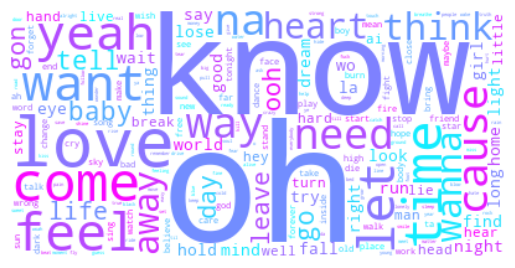

In [374]:
alllyrics_10s = np.array(lyrics_10s)
words_10s = ' '.join(alllyrics_10s)
wordcloud_10s = WordCloud(collocations=False, colormap="cool", background_color="white").generate(words_10s)
plt.imshow(wordcloud_10s, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2020 Clusters

3,328 songs

In [238]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(lyrics_20s)
type(features)

scipy.sparse._csr.csr_matrix

In [239]:
features.shape

(3328, 6548)

In [240]:
features = features.todense()
features = np.array(features)

After looking at silhouette scores below, 20 clusters looks like a good number for this decade.

In [241]:
model = KMeans(n_clusters=20, random_state=42, n_init='auto')

In [242]:
model.fit(features)

KMeans(n_clusters=20, random_state=42)

In [243]:
cluster_labels = model.predict(features)

In [244]:
cluster_labels

array([ 0,  9,  9, ...,  9, 10, 10], dtype=int32)

In [245]:
np.bincount(cluster_labels)

array([ 72, 162, 190,  66, 120,  72, 813, 104,  64, 599, 151, 134,  34,
        58,  42, 101, 108,  20, 108, 310])

Now I will look at silhouette scores to find the optimal number of clusters.

In [217]:
wss = []
for n in range(2, 31):
    print(n)
    model = KMeans(n_clusters=n, random_state=42, n_init='auto')
    model.fit(features)
    cluster_labels = model.predict(features)
    score = metrics.silhouette_score(features, cluster_labels)
    print('Silhouette score for ',n,' clusters: ',score)
    wss.append(-model.score(features))

2
Silhouette score for  2  clusters:  0.0017814139074906652
3
Silhouette score for  3  clusters:  0.0007109557371382433
4
Silhouette score for  4  clusters:  0.0041626167359009834
5
Silhouette score for  5  clusters:  0.004458725947287042
6
Silhouette score for  6  clusters:  0.005876884673566527
7
Silhouette score for  7  clusters:  0.006560621482633888
8
Silhouette score for  8  clusters:  0.008828340743663008
9
Silhouette score for  9  clusters:  0.009291488229828417
10
Silhouette score for  10  clusters:  0.0075354179931265836
11
Silhouette score for  11  clusters:  0.0073763615276126035
12
Silhouette score for  12  clusters:  0.008480792283400707
13
Silhouette score for  13  clusters:  0.011382474964114956
14
Silhouette score for  14  clusters:  0.012069369616401034
15
Silhouette score for  15  clusters:  0.01343270608474149
16
Silhouette score for  16  clusters:  0.013766063871495161
17
Silhouette score for  17  clusters:  0.014250366206729622
18
Silhouette score for  18  cluster

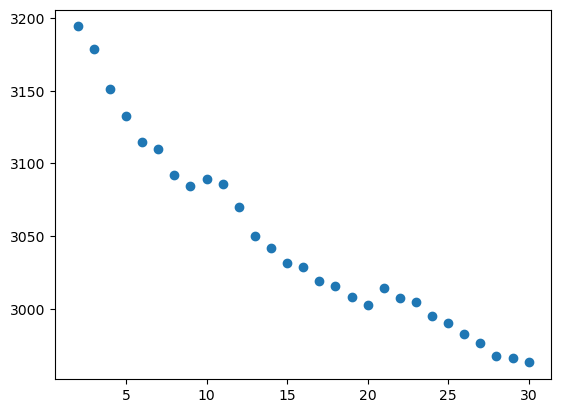

In [218]:
plt.scatter(range(2, 31), wss)

10 clusters still looks pretty good and is manageable.

### 2020s Cluster Representations

Twenty clusters for the 2020s.

In [219]:
cluster0_20s = np.array(lyrics_20s)[cluster_labels == 0]
wordcount0_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_20s)))
wordcount0_20s.most_common(10)

[('fall', 434),
 ('love', 190),
 ('know', 77),
 ('time', 53),
 ('heart', 45),
 ('like', 43),
 ('hang', 42),
 ('night', 41),
 ('think', 36),
 ('watch', 34)]

In [220]:
cluster1_20s = np.array(lyrics_20s)[cluster_labels == 1]
wordcount1_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_20s)))
wordcount1_20s.most_common(10)

[('want', 946),
 ('run', 349),
 ('know', 327),
 ('away', 308),
 ('get', 156),
 ('like', 149),
 ('na', 144),
 ('feel', 125),
 ('tell', 117),
 ('oh', 113)]

In [221]:
cluster2_20s = np.array(lyrics_20s)[cluster_labels == 2]
wordcount2_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster2_20s)))
wordcount2_20s.most_common(10)

[('lose', 387),
 ('time', 356),
 ('mind', 346),
 ('get', 131),
 ('oh', 122),
 ('tell', 120),
 ('know', 115),
 ('mi', 112),
 ('like', 108),
 ('want', 93)]

In [222]:
cluster3_20s = np.array(lyrics_20s)[cluster_labels == 3]
wordcount3_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster3_20s)))
wordcount3_20s.most_common(10)

[('ooh', 1796),
 ('know', 158),
 ('na', 146),
 ('oh', 138),
 ('get', 122),
 ('like', 108),
 ('yeah', 88),
 ('love', 66),
 ("'cause", 58),
 ('life', 58)]

In [223]:
cluster4_20s = np.array(lyrics_20s)[cluster_labels == 4]
wordcount4_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster4_20s)))
wordcount4_20s.most_common(10)

[('na', 1450),
 ('get', 1091),
 ('know', 1052),
 ('oh', 1041),
 ('like', 972),
 ('yeah', 857),
 ('need', 771),
 ('love', 703),
 ('gon', 659),
 ('time', 637)]

In [224]:
cluster5_20s = np.array(lyrics_20s)[cluster_labels == 5]
wordcount5_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster5_20s)))
wordcount5_20s.most_common(10)

[('oh', 2319),
 ('love', 258),
 ('know', 248),
 ('na', 246),
 ('let', 191),
 ('yeah', 167),
 ('baby', 164),
 ('heart', 142),
 ('like', 133),
 ('get', 112)]

In [225]:
cluster6_20s = np.array(lyrics_20s)[cluster_labels == 6]
wordcount6_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster6_20s)))
wordcount6_20s.most_common(10)

[('little', 492),
 ('bit', 221),
 ('love', 125),
 ('oh', 100),
 ('lot', 85),
 ('want', 83),
 ('know', 78),
 ('get', 76),
 ('think', 68),
 ('time', 57)]

In [226]:
cluster7_20s = np.array(lyrics_20s)[cluster_labels == 7]
wordcount7_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster7_20s)))
wordcount7_20s.most_common(10)

[('like', 1210),
 ('feel', 945),
 ('know', 291),
 ('get', 220),
 ('love', 173),
 ('way', 156),
 ('time', 152),
 ('na', 151),
 ('yeah', 149),
 ('think', 145)]

In [227]:
cluster8_20s = np.array(lyrics_20s)[cluster_labels == 8]
wordcount8_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster8_20s)))
wordcount8_20s.most_common(10)

[('change', 287),
 ('love', 67),
 ('suppose', 64),
 ('na', 59),
 ('gon', 59),
 ('heart', 52),
 ('feel', 51),
 ('oh', 48),
 ('know', 42),
 ('like', 37)]

In [228]:
cluster9_20s = np.array(lyrics_20s)[cluster_labels == 9]
wordcount9_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster9_20s)))
wordcount9_20s.most_common(10)

[('love', 2019),
 ('like', 218),
 ('know', 178),
 ('na', 177),
 ('want', 113),
 ('oh', 112),
 ('need', 110),
 ('feel', 106),
 ('time', 105),
 ('wan', 101)]

In [246]:
cluster10_20s = np.array(lyrics_20s)[cluster_labels == 10]
wordcount10_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster10_20s)))
wordcount10_20s.most_common(10)

[('love', 2417),
 ('know', 366),
 ('fall', 361),
 ('like', 306),
 ('oh', 203),
 ('want', 188),
 ('time', 173),
 ('na', 172),
 ("'cause", 172),
 ('high', 163)]

In [247]:
cluster11_20s = np.array(lyrics_20s)[cluster_labels == 11]
wordcount11_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster11_20s)))
wordcount11_20s.most_common(10)

[('na', 1659),
 ('gon', 964),
 ('know', 332),
 ('like', 264),
 ('yeah', 208),
 ('oh', 203),
 ('get', 194),
 ('love', 192),
 ('come', 154),
 ('time', 133)]

In [248]:
cluster12_20s = np.array(lyrics_20s)[cluster_labels == 12]
wordcount12_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster12_20s)))
wordcount12_20s.most_common(10)

[('la', 1300),
 ('oh', 182),
 ('like', 104),
 ('love', 94),
 ('know', 80),
 ('need', 62),
 ('get', 61),
 ('hard', 61),
 ('tell', 52),
 ('feel', 44)]

In [249]:
cluster13_20s = np.array(lyrics_20s)[cluster_labels == 13]
wordcount13_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster13_20s)))
wordcount13_20s.most_common(10)

[('hey', 536),
 ('stay', 254),
 ('tonight', 200),
 ('know', 191),
 ('get', 122),
 ('wo', 119),
 ('like', 103),
 ('feel', 98),
 ('let', 97),
 ('night', 97)]

In [250]:
cluster14_20s = np.array(lyrics_20s)[cluster_labels == 14]
wordcount14_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster14_20s)))
wordcount14_20s.most_common(10)

[('ah', 769),
 ('na', 99),
 ('oh', 87),
 ('yeah', 80),
 ('like', 72),
 ('know', 70),
 ('feel', 60),
 ('wan', 58),
 ('need', 53),
 ('love', 50)]

In [251]:
cluster15_20s = np.array(lyrics_20s)[cluster_labels == 15]
wordcount15_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster15_20s)))
wordcount15_20s.most_common(10)

[('na', 1408),
 ('wan', 1364),
 ('know', 445),
 ('like', 279),
 ('feel', 230),
 ('love', 178),
 ('play', 154),
 ('come', 153),
 ('way', 147),
 ('time', 125)]

In [252]:
cluster16_20s = np.array(lyrics_20s)[cluster_labels == 16]
wordcount16_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster16_20s)))
wordcount16_20s.most_common(10)

[('yeah', 1541),
 ('know', 348),
 ('get', 283),
 ('oh', 283),
 ('like', 247),
 ('need', 189),
 ('love', 147),
 ('want', 147),
 ('na', 139),
 ('baby', 136)]

In [253]:
cluster17_20s = np.array(lyrics_20s)[cluster_labels == 17]
wordcount17_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster17_20s)))
wordcount17_20s.most_common(10)

[('get', 151),
 ('gold', 147),
 ('lovin', 86),
 ("'", 86),
 ('ooh', 77),
 ('know', 71),
 ('yeah', 66),
 ('oh', 62),
 ('mmm', 58),
 ('love', 53)]

In [254]:
cluster18_20s = np.array(lyrics_20s)[cluster_labels == 18]
wordcount18_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster18_20s)))
wordcount18_20s.most_common(10)

[('oh', 2392),
 ('love', 281),
 ('know', 235),
 ('yeah', 203),
 ('let', 192),
 ('baby', 155),
 ('na', 151),
 ('heart', 148),
 ('like', 128),
 ('time', 109)]

In [255]:
cluster19_20s = np.array(lyrics_20s)[cluster_labels == 19]
wordcount19_20s = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster19_20s)))
wordcount19_20s.most_common(10)

[('like', 1440),
 ('feel', 1255),
 ('know', 851),
 ('get', 791),
 ('need', 597),
 ('way', 492),
 ('good', 491),
 ('bad', 372),
 ("'cause", 366),
 ('tell', 322)]

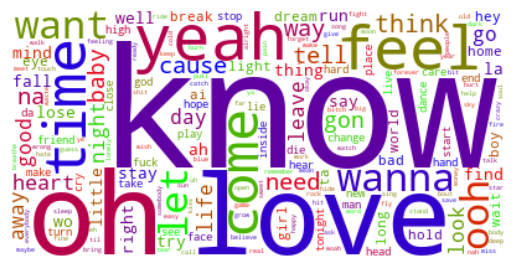

In [378]:
alllyrics_20s = np.array(lyrics_20s)
words_20s = ' '.join(alllyrics_20s)
wordcloud_20s = WordCloud(collocations=False, colormap="brg", background_color="white").generate(words_20s)
plt.imshow(wordcloud_20s, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud of All Lyrics

Finally, this is a wordcloud of all the lyrics, just to show what was most common overall. Many of these words were the biggest in the individual decades as well!

This [Stack Overflow page](https://stackoverflow.com/questions/43954114/python-wordcloud-repetitive-words) was helpful when trying to figure out why it was repeating words in my wordclouds. Adding the collocations=False made that go away and just focus on the individual words.

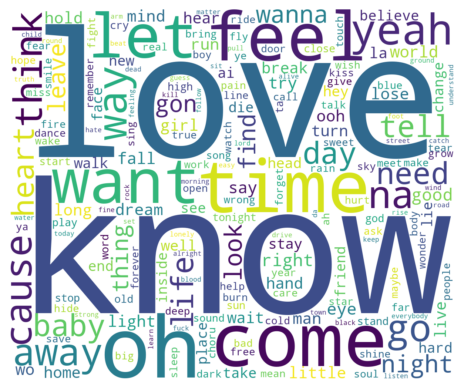

In [367]:
alllyrics = np.array(lyrics)
words = ' '.join(alllyrics)
wordcloud = WordCloud(collocations=False, background_color="white", colormap="viridis", 
                     width=1200, height=1000).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()